# **1. Import library**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix,  
    classification_report,
    mean_absolute_error, 
    mean_squared_error, 
    explained_variance_score,
    f1_score,
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

# **2. Load normalized data**

In [2]:
normalized_data = pd.read_csv('../processed_data/normalized_data.csv')
X = normalized_data.drop("attack_cat", axis=1).values
y = normalized_data["attack_cat"].values

In [3]:
X

array([[2.02463370e-03, 4.69704086e-04, 3.63042294e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.08317020e-02, 1.22123062e-03, 3.44890180e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.70521550e-02, 6.57585721e-04, 1.45216918e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.50000028e-07, 9.39408173e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [4]:
y

array(['Normal', 'Normal', 'Normal', ..., 'Normal', 'Normal', 'Normal'],
      dtype=object)

In [5]:
# Decode label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse_output=False)
y_onehot = onehot_encoder.fit_transform(y_encoded.reshape(-1, 1))

In [6]:
# Chuẩn hóa đặc trưng
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)

# **3. Build LSTM model**

In [8]:
# Reshape input
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = y_onehot.shape[1]

In [9]:
# LSTM model
model = Sequential()

model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=input_shape))
model.add(BatchNormalization())
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(BatchNormalization())

model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

d:\ML\env311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Compile model
optimizer = SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 256)         │       463,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 712,842 (2.72 MB)

 Trainable params: 711,946 (2.72 MB)

 Non-trainable params: 896 (3.50 KB)

# **4. Training model**

In [11]:
# Start time
start_time = time.time()

# Training model
model.fit(X_train, y_train, epochs=100, batch_size=120, validation_data=(X_test, y_test))

# End time
end_time = time.time()

Epoch 1/100
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.6896 - loss: 0.9524 - val_accuracy: 0.7638 - val_loss: 0.6318
Epoch 2/100
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7527 - loss: 0.6331 - val_accuracy: 0.7726 - val_loss: 0.5912
Epoch 3/100
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7639 - loss: 0.5970 - val_accuracy: 0.7777 - val_loss: 0.5779
Epoch 4/100
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7731 - loss: 0.5763 - val_accuracy: 0.7897 - val_loss: 0.5572
Epoch 5/100
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7775 - loss: 0.5643 - val_accuracy: 0.7907 - val_loss: 0.5492
Epoch 6/100
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7831 - loss: 0.5502 - val_accuracy: 0.7927 - val_loss: 0.5467
Epoch 7/100
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.7845 - loss: 0.5444 - val_accuracy: 0.7939 - val_loss: 0.5463
Epoch 8/100
1718/1718 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7884 -

In [12]:
# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

1611/1611 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [13]:
# Save model
model.save('../models/lstm.h5')

# **5. Confusion matrix**

In [14]:
# Create confusion matrix
confusion_matrix_result = confusion_matrix(y_test_labels, y_pred_labels, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
confusion_matrix_result

array([[   24,     0,    20,   358,    15,     0,   102,     0,     0,
            0],
       [    0,    29,    23,   385,    21,     3,     4,     2,     1,
            0],
       [    0,     8,   311,  2828,    49,    12,    62,    10,    12,
            0],
       [    7,    12,   254,  8332,   157,    21,   205,    68,    24,
            0],
       [    0,     0,    28,   602,  2672,     2,  1511,     9,     7,
            0],
       [    0,     0,    19,   171,    26, 11305,    11,     3,     1,
            1],
       [    0,     0,    15,   175,   977,     6, 17406,    21,    13,
            0],
       [    0,     3,    42,   765,    91,     1,   335,  1590,    25,
            0],
       [    0,     0,     9,    92,    28,     1,    38,    14,   127,
            0],
       [    0,     0,     1,    25,     1,     1,     0,     0,     0,
            6]], dtype=int64)

In [15]:
# Calculate confusion matrix
# Compute confusion matrix
def plot_confusion_matrix(
        cm,
        target_names,
        title='Confusion matrix',
        cmap=None,
        normalize=True
):
    
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [16]:
target_names=[
    'Analysis', 
    'Backdoor', 
    'DoS', 
    'Exploits', 
    'Fuzzers', 
    'Generic', 
    'Normal', 
    'Reconnaissance', 
    'Shellcode', 
    'Worms'
]

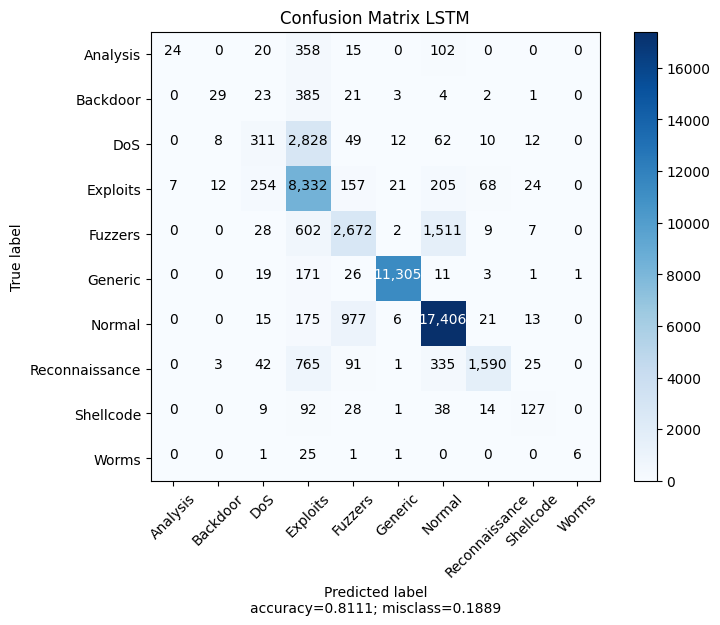

In [17]:
# Plot confusion matrix
plot_confusion_matrix(
    confusion_matrix_result, 
    normalize=False,
    target_names=target_names, 
    title="Confusion Matrix LSTM"
)

# **6. Calculate metrics**

In [18]:
# Training time
training_time = end_time - start_time
print(f"Training time: {training_time/60/60:.2f} hours")

Training time: 0.36 hours


In [19]:
# Tính Detection Rate và False Positive Rate
tp = np.diag(confusion_matrix_result)  # True Positives
fn = np.sum(confusion_matrix_result, axis=1) - tp  # False Negatives
fp = np.sum(confusion_matrix_result, axis=0) - tp  # False Positives

In [20]:
detection_rate = tp / (tp + fn)
fpr = fp / (fp + np.sum(confusion_matrix_result, axis=1) - tp)
df = pd.DataFrame({"Class": target_names, "False Positive Rate": fpr, "Detection Rate": detection_rate})

# Hiển thị bảng
print(df)

            Class  False Positive Rate  Detection Rate
0        Analysis             0.013944        0.046243
1        Backdoor             0.049784        0.061966
2             DoS             0.121167        0.094471
3        Exploits             0.878354        0.917621
4         Fuzzers             0.387344        0.553095
5         Generic             0.168459        0.979891
6          Normal             0.652662        0.935153
7  Reconnaissance             0.091433        0.557504
8       Shellcode             0.313208        0.411003
9           Worms             0.034483        0.176471


In [21]:
# Hiển thị báo cáo phân loại
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

                precision    recall  f1-score   support

      Analysis       0.77      0.05      0.09       519
      Backdoor       0.56      0.06      0.11       468
           DoS       0.43      0.09      0.15      3292
      Exploits       0.61      0.92      0.73      9080
       Fuzzers       0.66      0.55      0.60      4831
       Generic       1.00      0.98      0.99     11537
        Normal       0.88      0.94      0.91     18613
Reconnaissance       0.93      0.56      0.70      2852
     Shellcode       0.60      0.41      0.49       309
         Worms       0.86      0.18      0.29        34

      accuracy                           0.81     51535
     macro avg       0.73      0.47      0.51     51535
  weighted avg       0.81      0.81      0.79     51535



In [22]:
print("Mean Absolute Error - ", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - ", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score - ", explained_variance_score(y_test, y_pred) * 100)
print("F1 Score (weighted): ", f1_score(y_test_labels, y_pred_labels, average='weighted') * 100)
print("Accuracy - ",accuracy_score(y_test_labels, y_pred_labels)*100)

Mean Absolute Error -  0.04752120238970548
Mean Squared Error -  0.023961303853574954
Root Mean Squared Error -  0.15479439219033406
R2 Score -  44.34561813413662
F1 Score (weighted):  78.81558601300766
Accuracy -  81.11380615115941
